In [1]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 18.6MB/s 
     |████████████████████████████████| 952kB 39.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=d36f2025de25ed701c4bcbafb7535fdacfa1b7f25195b717f3dbaedf851ed133
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!pip install torch torchvision torchaudio

     |████████████████████████████████| 1.9MB 20.2MB/s 


In [3]:
from time import time
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

torch.cuda.empty_cache() 

import os

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from os import chdir

In [6]:
chdir('gdrive/MyDrive/TipsAndTripcksProject ')

In [7]:
DATA_PATH = 'Data/Data/'
os.listdir(DATA_PATH)

['Annotations', 'daySequence2', 'daySequence1', 'dayTrain', 'sample-dayClip6']

In [8]:
DATA_TRAIN_PATH = 'Data/Data/Annotations/Annotations/dayTrain/'

In [13]:
# !pip install torch torchvision torchaudio

In [9]:
from tqdm import tqdm

In [10]:
train_day = []
clipNames = sorted(os.listdir(DATA_TRAIN_PATH))[1:]
for clipName in tqdm(clipNames):
    df = pd.read_csv(os.path.join(DATA_TRAIN_PATH, clipName, 'frameAnnotationsBOX.csv'), sep=';')
    train_day.append(df)


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


In [11]:
train_day_df = pd.concat(train_day, axis=0).reset_index(drop=True)

In [12]:
train_day_df.Filename[0]

'dayTraining/dayClip1--00000.jpg'

In [13]:
train_day_df = train_day_df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)
# df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [14]:
train_day_df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,1
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,1
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,2


In [15]:
def changeFilename(x):
    x = x.strip().split('/')    
    clipName = x[-1].split('--')[0]
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{x[-1]}')

In [16]:
train_day_df['Filename'] = train_day_df['Filename'].apply(lambda x: changeFilename(x))
# df['Filename'] = df['Filename'].apply(lambda x: changeFilename(x))

In [17]:
train_day_df.Filename[0]

'Data/Data/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg'

In [18]:
df['Annotation tag'].unique()

array(['stop', 'stopLeft', 'go', 'goLeft', 'warningLeft'], dtype=object)

In [19]:
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

In [20]:
df = train_day_df.copy()

In [21]:
def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([1, 3, 2])

In [22]:
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame']

In [23]:
df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame
0,Data/Data/dayTrain/dayTrain/dayClip1/frames/da...,1,698,333,710,358,0
1,Data/Data/dayTrain/dayTrain/dayClip1/frames/da...,1,846,391,858,411,0
2,Data/Data/dayTrain/dayTrain/dayClip1/frames/da...,1,698,337,710,357,1
3,Data/Data/dayTrain/dayTrain/dayClip1/frames/da...,1,847,390,859,410,1
4,Data/Data/dayTrain/dayTrain/dayClip1/frames/da...,1,698,331,710,356,2


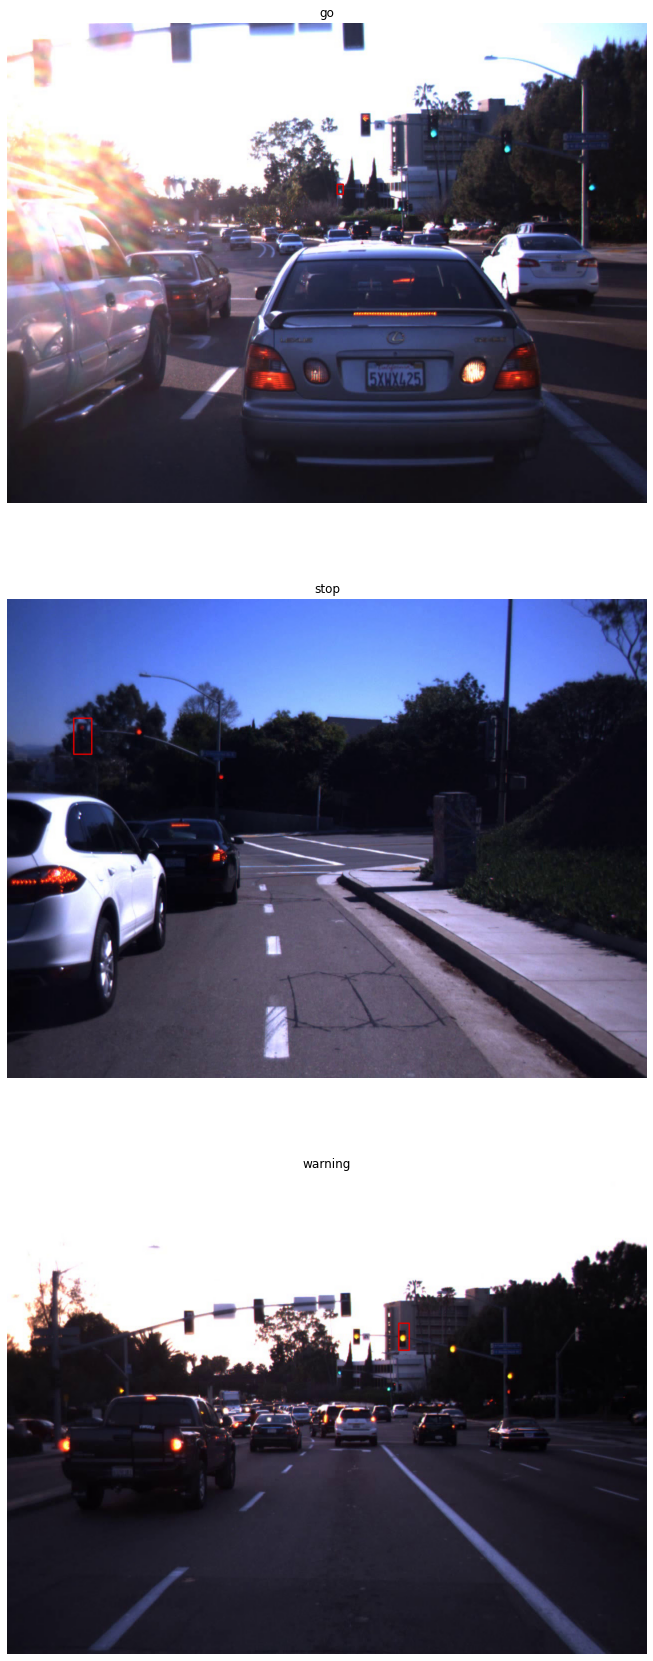

In [24]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [25]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[4])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9'], dtype=object)

In [26]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    dayClips = [name for name in clipNames if 'day' in name]

    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames =  testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainClipNames =  trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [27]:
train_df, test_df = split(df)
train_df, val_df = split(train_df)

### Hyperparameters

In [28]:
EPOCHS = 1
BATCH_SIZE = 2

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [30]:
df.head(2)

,image_id,label,x_min,y_min,x_max,y_max,frame,clipNames
0,Data/Data/dayTrain/dayTrain/dayClip1/frames/da...,1,698,333,710,358,0,dayClip1
1,Data/Data/dayTrain/dayTrain/dayClip1/frames/da...,1,846,391,858,411,0,dayClip1


### Defining dataset and Dataloader

In [31]:
class TrafficLightsDataset:
    def __init__(self, df , transforms = None):
        super().__init__()

        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms

    def __len__(self) -> int:
        return self.image_ids.shape[0]
      
    def __getitem__(self, index:int):
        image_id = self.image_ids[index]
        records = self.df[df.image_id == image_id]

        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:,3] - boxes[:,1])*(boxes[:,2] - boxes[:,0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        iscrowed = torch.zeros_like(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['area'] = area
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['iscrowed'] = iscrowed

        if self.transforms:

            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }

            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'], dtype=torch.int64)

          
        return image, target, image_id






In [32]:
class LossAverager:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
      

In [33]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [34]:
def getTrainTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getValTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getTestTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [35]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())

In [36]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

### Display Frames

In [37]:
images, target, image_id = next(iter(trainDataLoader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [38]:
boxes = target[0]['boxes'].numpy().astype(np.int32)
image = images[0].permute(1,2,0).numpy()

In [39]:
def displayImage(image, boxes):
    fix, ax = plt.subplots(1, 1, figsize=(16,8))
    for box in boxes:
        cv2.rectangle(image, (box[0], box[1]), (box[2],box[3]), (220, 0, 0), 1)

    ax.set_axis_off()
    ax.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


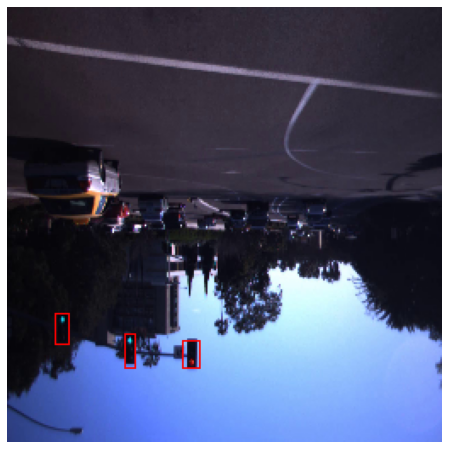

In [40]:
displayImage(image, boxes)

### Training FasterRCNN model

In [41]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

N_CLASS = 4 


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [42]:
INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

In [43]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params)

lr_scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [51]:
lossHist = LossAverager()
valLossHist = LossAverager()

for epoch in range(EPOCHS):
    
    start_time = time()
    model.train()
    lossHist.reset()
    
    for images, targets, image_ids in tqdm(trainDataLoader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        lossHist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
    
    if lr_scheduler is not None:
        lr_scheduler.step(totalLoss)

    # print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {lossHist.avg}")
    
    if(epoch == 10):
        torch.save(model.state_dict(), 'fasterrcnn_resnet{}_fpn.pth'.format(epoch))


  0%|          | 0/3134 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
100%|██████████| 3134/3134 [54:22<00:00,  1.04s/it]

Epoch 0/1
Train loss: 0.2610264282302732


In [52]:
torch.save(model.state_dict(), 'fasterrcnn_resnet{}_fpn.pth'.format(epoch))


NameError: ignored

In [49]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

N_CLASS = 4 

INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [44]:
model.load_state_dict(torch.load('fasterrcnn_resnet0_fpn.pth'))

<All keys matched successfully>

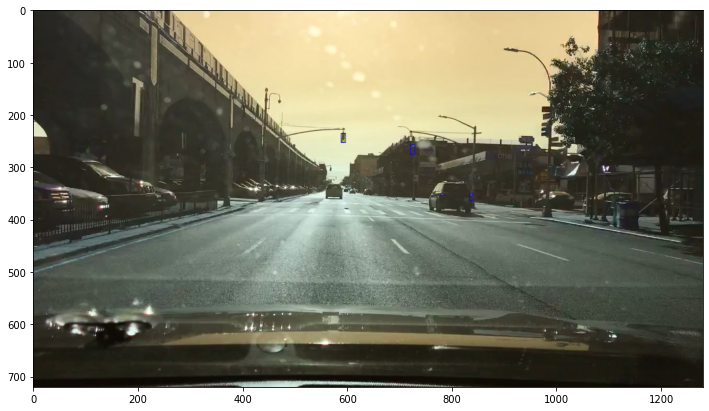

In [56]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

cap = cv2.VideoCapture("Videos/video_0.mp4")
model.eval()
while True:
    ret, input = cap.read()
    image = input.copy()
    input = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input = preprocess(input).float()
    input = input.unsqueeze_(0)
    input = input.type(torch.cuda.FloatTensor)

    result = model(input)

    boxes = result[0]['boxes'].type(torch.cuda.FloatTensor)
    scores = result[0]['scores'].type(torch.cuda.FloatTensor)
    labels = result[0]['labels'].type(torch.cuda.FloatTensor)

    mask = nms(boxes,scores,0.3)
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()

    mask = scores >= 0.5
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}

    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0,0,255), 1)

    plt.figure(figsize=(12,7))
    plt.imshow(image)
    
    if cv2.waitKey(0):
        break

In [47]:
image.shape

(720, 1280, 3)

In [55]:
boxes

array([[588, 235, 597, 253],
       [833, 349, 840, 363],
       [721, 257, 729, 275]], dtype=int32)

In [49]:
boxes

array([[834, 350, 839, 364]], dtype=int32)

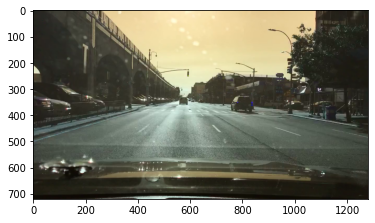

In [48]:
plt.imshow(image)

In [60]:
input